In [150]:
cores = 64
mutex_data = {}
spinlock_data = {}
for i in range(1, cores + 1):
    with open('mutex-{}.txt'.format(i)) as f:
        lines = f.readlines()
        lines = [int(line) for line in lines]
        mutex_data[i] = lines
    with open('spinlock-{}.txt'.format(i)) as f:
        lines = f.readlines()
        lines = [int(line) for line in lines]
        spinlock_data[i] = lines

In [151]:
import pandas
mutex_data = pandas.DataFrame(mutex_data)
spinlock_data = pandas.DataFrame(spinlock_data)
mutex_series = mutex_data.median()
spinlock_series = spinlock_data.median()

In [152]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns

sns.set()
sns.set_style("whitegrid")

matplotlib.rcParams['figure.figsize'] = (20, 10)
matplotlib.rcParams['figure.dpi'] = 200

In [153]:
def fit_curve(x, y, f):
    popt, _ = curve_fit(f, x, y)
    p = lambda z: f(z, *popt)
    yhat = p(x)
    ybar = np.sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    return {
        'polynomial': lambda x: f(x, *popt),
        'r-squared': ssreg/sstot,
    }

def fit_polynomial(x, y, degree):
    coeffs = np.polyfit(x, y, degree)
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    return {'polynomial': p, 'r-squared': ssreg/sstot}

In [154]:
rs = {}
for i in range(5, len(spinlock_series)//2):
    fit = fit_polynomial(spinlock_series.index[:i], spinlock_series[:i], 1)
    rs[i] = [fit['r-squared']]
pandas.DataFrame(rs).T

0
5   0.974579
6   0.985423
7   0.988852
8   0.969373
9   0.975662
10  0.924244
11  0.914126
12  0.933258
13  0.944592
14  0.954065
15  0.961996
16  0.965476
17  0.970145
18  0.965957
19  0.967889
20  0.971944
21  0.972787
22  0.974747
23  0.976045
24  0.978857
25  0.981236
26  0.970459
27  0.969677
28  0.935744
29  0.904388
30  0.913514
31  0.872716

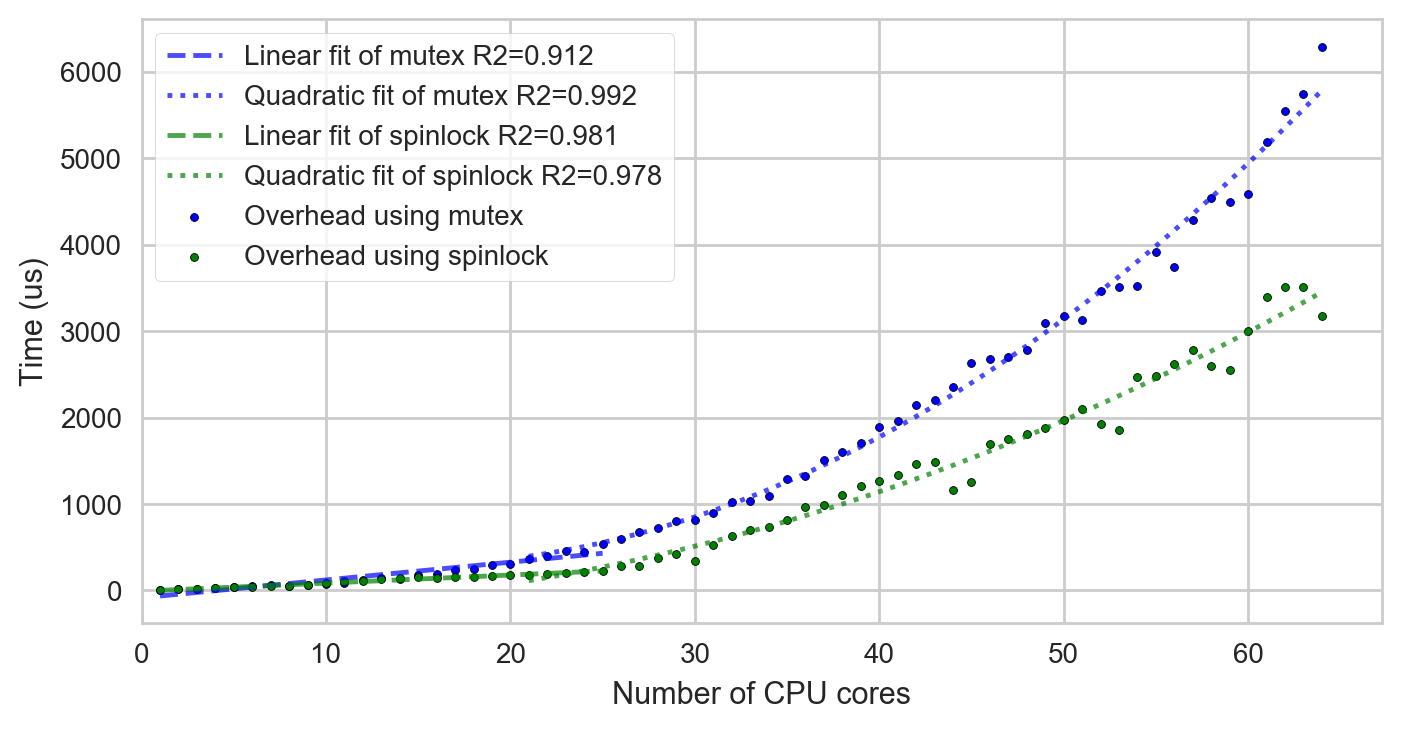

In [183]:
cut = 25
headroom = 5

plt.figure(figsize=(8, 4))
plt.scatter(mutex_series.index, mutex_series, c='b', s=8, edgecolor='k', label='Overhead using mutex')
linear_fit = fit_polynomial(mutex_series.index[:cut], mutex_series[:cut], 1)
plt.plot(mutex_series.index[:cut], linear_fit['polynomial'](mutex_series.index[:cut]), 'b--', alpha=0.7, label='Linear fit of mutex R2={:.3f}'.format(linear_fit['r-squared']))
quadratic_fit = fit_polynomial(mutex_series.index[cut-headroom:], mutex_series[cut-headroom:], 2)
plt.plot(mutex_series.index[cut-headroom:], quadratic_fit['polynomial'](mutex_series.index[cut-headroom:]), 'b:', alpha=0.7, label='Quadratic fit of mutex R2={:.3f}'.format(quadratic_fit['r-squared']))

plt.scatter(spinlock_series.index, spinlock_series, c='g', s=8, edgecolor='k', label='Overhead using spinlock')
linear_fit = fit_polynomial(spinlock_series.index[:cut], spinlock_series[:cut], 1)
plt.plot(spinlock_series.index[:cut], linear_fit['polynomial'](spinlock_series.index[:cut]), 'g--', alpha=0.7, label='Linear fit of spinlock R2={:.3f}'.format(linear_fit['r-squared']))
quadratic_fit = fit_polynomial(spinlock_series.index[cut-headroom:], spinlock_series[cut-headroom:], 2)
plt.plot(spinlock_series.index[cut-headroom:], quadratic_fit['polynomial'](spinlock_series.index[cut-headroom:]), 'g:', alpha=0.7, label='Quadratic fit of spinlock R2={:.3f}'.format(quadratic_fit['r-squared']))

axes = plt.gca()
axes.set_xlim(left=0)
handles, labels = axes.get_legend_handles_labels()
axes.legend(handles, labels, frameon=True)
axes.set_xlabel('Number of CPU cores')
axes.set_ylabel('Time (us)')
plt.savefig('measurements.pgf')

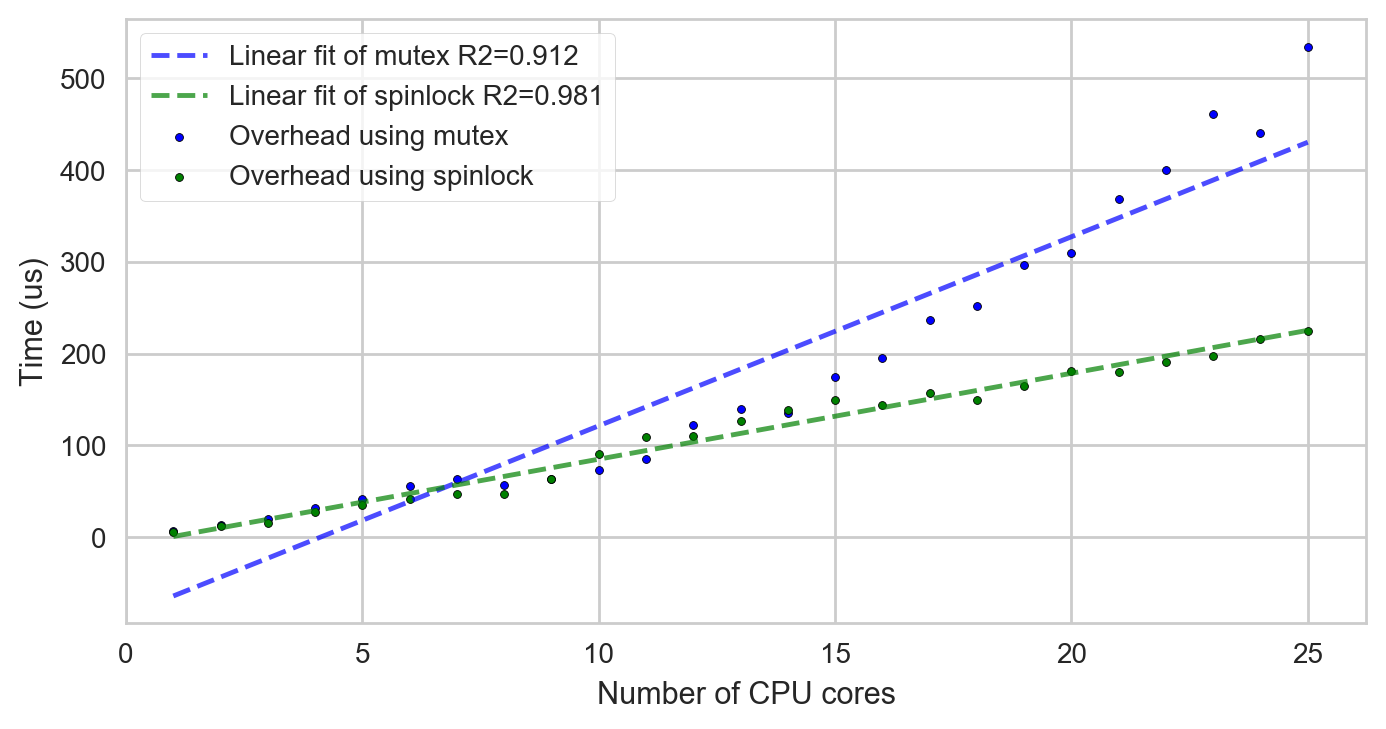

In [184]:
cut = 25

plt.figure(figsize=(8, 4.0))
plt.scatter(mutex_series.index[:cut], mutex_series[:cut], c='b', s=8, edgecolor='k', label='Overhead using mutex')
linear_fit = fit_polynomial(mutex_series.index[:cut], mutex_series[:cut], 1)
plt.plot(mutex_series.index[:cut], linear_fit['polynomial'](mutex_series.index[:cut]), 'b--', alpha=0.7, label='Linear fit of mutex R2={:.3f}'.format(linear_fit['r-squared']))

plt.scatter(spinlock_series.index[:cut], spinlock_series[:cut], c='g', s=8, edgecolor='k', label='Overhead using spinlock')
linear_fit = fit_polynomial(spinlock_series.index[:cut], spinlock_series[:cut], 1)
plt.plot(spinlock_series.index[:cut], linear_fit['polynomial'](spinlock_series.index[:cut]), 'g--', alpha=0.7, label='Linear fit of spinlock R2={:.3f}'.format(linear_fit['r-squared']))

axes = plt.gca()
axes.set_xlim(left=0)
handles, labels = axes.get_legend_handles_labels()
axes.legend(handles, labels, frameon=True)
axes.set_xlabel('Number of CPU cores')
axes.set_ylabel('Time (us)')
plt.savefig('measurements_linear.pgf')